# AlphaGenome Predictions vs. Patient RNA-seq

> **⚠️ These are AlphaGenome model predictions, not validated experimental results.**
> This notebook compares the model's predicted expression values against observed RNA-seq data
> from TCGA patient **TCGA-05-4384 (LUAD)**. It is a consistency check, not an independent
> validation of model accuracy.

**Key context:**
- AlphaGenome's REF_EXPR / ALT_EXPR are summed RNA-seq track values over a **1 MB window** centred on the variant — they include all genes and regulatory elements in that window.
- TPM is a normalised per-gene measure. The two are **not directly comparable** in absolute terms — only relative trends are meaningful.
- All 8 variants were predicted as **Neutral** (log₂FC < ±0.005).
- With n = 8, statistical power is very low (need r ≈ 0.71 for significance at α = 0.05).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.stats import t as t_dist

sns.set_theme(style="whitegrid", context="notebook", palette="colorblind")
plt.rcParams["figure.dpi"] = 120

# Priority colour map
PRIORITY_COLORS = {"HIGH": "#d62728", "MEDIUM": "#ff7f0e", "LOW": "#2ca02c"}

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


## 1. Load Validation Data

In [2]:
df = pd.read_csv("../output/validation_table.csv")
corr_df = pd.read_csv("../output/validation_correlations.csv")

print(f"Validation table: {len(df)} variants, {df.shape[1]} columns")
display(df[["GENE", "REF_EXPR", "ALT_EXPR", "LOG2_FC", "OBSERVED_TPM",
            "unstranded", "VAF", "NMD_FLAG", "VACCINE_PRIORITY"]])
print()
display(corr_df)

Validation table: 8 variants, 17 columns


,GENE,REF_EXPR,ALT_EXPR,LOG2_FC,OBSERVED_TPM,unstranded,VAF,NMD_FLAG,VACCINE_PRIORITY
0,TTC7A,134680.203125,134495.765625,-0.0020,26.33,1724,0.250,True,LOW
1,FAM107A,106168.765625,106162.679688,-0.0001,10.14,492,0.236,False,HIGH
2,ELFN1-AS1,70284.382812,70282.351562,-0.0000,0.44,4,0.415,False,MEDIUM
3,LAMC3,141536.968750,141971.546875,0.0044,25.02,2039,0.456,False,HIGH
4,TMTC1,34362.179688,34393.191406,0.0013,4.90,656,0.171,False,MEDIUM
5,MMP25,218182.875000,218129.609375,-0.0004,4.47,173,0.135,False,MEDIUM
6,ERBB2,272123.718750,271699.406250,-0.0023,222.22,20912,0.360,True,LOW
7,DOT1L,257204.343750,257514.640625,0.0017,6.31,661,0.351,False,HIGH


,comparison,x,y,transform,n,pearson_r,pearson_p,spearman_rho,spearman_p
0,ALT_EXPR vs OBSERVED_TPM,ALT_EXPR,OBSERVED_TPM,none,8,0.547943,0.159728,0.476190,0.232936
1,ALT_EXPR vs OBSERVED_TPM (log₁₀),ALT_EXPR,OBSERVED_TPM,log10,8,0.511206,0.195389,0.476190,0.232936
2,REF_EXPR vs OBSERVED_TPM,REF_EXPR,OBSERVED_TPM,none,8,0.549644,0.158170,0.476190,0.232936
3,REF_EXPR vs OBSERVED_TPM (log₁₀),REF_EXPR,OBSERVED_TPM,log10,8,0.511595,0.194991,0.476190,0.232936
4,LOG2_FC vs OBSERVED_TPM,LOG2_FC,OBSERVED_TPM,none,8,-0.472500,0.237092,-0.357143,0.385121
5,ALT_EXPR vs raw_counts,ALT_EXPR,unstranded,none,8,0.546399,0.161149,0.547619,0.160026
6,ALT_EXPR vs raw_counts (log₁₀),ALT_EXPR,unstranded,log10,8,0.429823,0.287841,0.547619,0.160026
7,"ALT_EXPR vs TPM (expressed only, TPM≥1)",ALT_EXPR,OBSERVED_TPM,none,7,0.521272,0.230218,0.285714,0.534509


## 2. Data Preprocessing & Log Transformations

Create log₁₀-transformed columns using log₁₀(x + 1) to handle zeros. These compress the dynamic range and reduce the influence of the ERBB2 outlier (TPM = 222).

In [3]:
# Log₁₀ transforms  (log10(x + 1) to handle zeros)
df["log10_ALT_EXPR"] = np.log10(df["ALT_EXPR"] + 1)
df["log10_REF_EXPR"] = np.log10(df["REF_EXPR"] + 1)
df["log10_TPM"] = np.log10(df["OBSERVED_TPM"] + 1)
df["log10_COUNTS"] = np.log10(df["unstranded"] + 1)
df["ABS_LOG2_FC"] = df["LOG2_FC"].abs()

# Encode categorical columns numerically for the heatmap later
priority_map = {"HIGH": 3, "MEDIUM": 2, "LOW": 1}
df["PRIORITY_NUM"] = df["VACCINE_PRIORITY"].map(priority_map)
df["NMD_NUM"] = df["NMD_FLAG"].astype(int)

display(df[["GENE", "log10_ALT_EXPR", "log10_TPM", "log10_COUNTS", "ABS_LOG2_FC"]].round(3))

,GENE,log10_ALT_EXPR,log10_TPM,log10_COUNTS,ABS_LOG2_FC
0,TTC7A,5.129,1.437,3.237,0.002
1,FAM107A,5.026,1.047,2.693,0.000
2,ELFN1-AS1,4.847,0.158,0.699,0.000
3,LAMC3,5.152,1.415,3.310,0.004
4,TMTC1,4.536,0.771,2.818,0.001
5,MMP25,5.339,0.738,2.241,0.000
6,ERBB2,5.434,2.349,4.320,0.002
7,DOT1L,5.411,0.864,2.821,0.002


## 3. Scatter: Predicted Expression vs Observed TPM

ALT_EXPR (summed AlphaGenome RNA-seq track over 1 MB window) vs. OBSERVED_TPM (per-gene normalised expression). Points coloured by vaccine priority. Note the **very different scales** — only relative ranking matters.

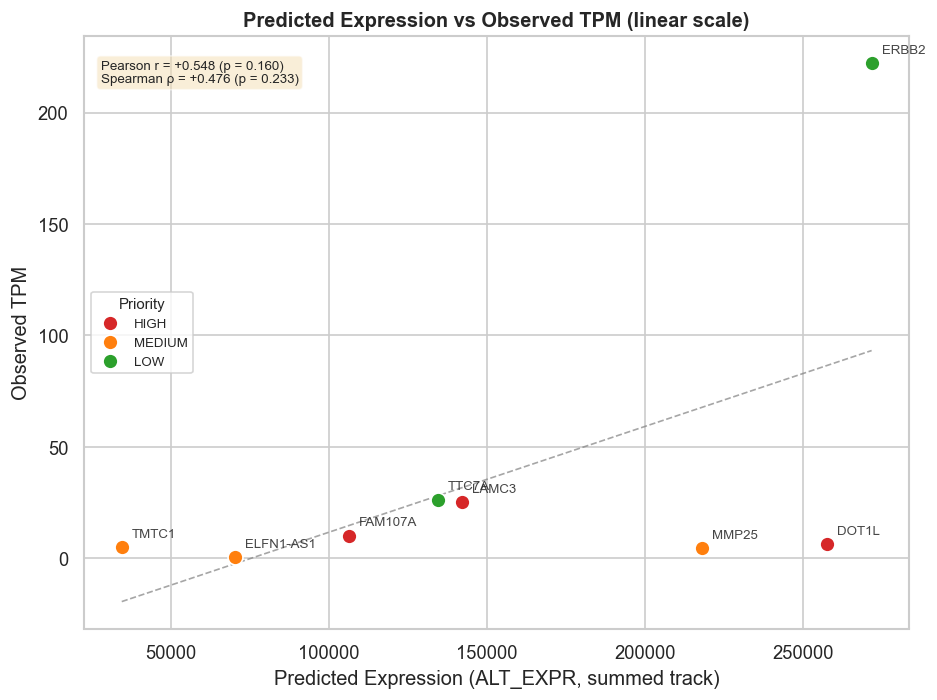

In [4]:
def scatter_with_regression(ax, x, y, df, xlabel, ylabel, title,
                            color_col="VACCINE_PRIORITY", label_col="GENE"):
    """Scatter plot with per-priority colours, gene labels, and regression line."""
    for priority, color in PRIORITY_COLORS.items():
        mask = df[color_col] == priority
        ax.scatter(df.loc[mask, x], df.loc[mask, y],
                   c=color, label=priority, s=80, edgecolors="white", zorder=3)
    # Gene labels
    for _, row in df.iterrows():
        ax.annotate(row[label_col],
                    (row[x], row[y]),
                    textcoords="offset points", xytext=(6, 6),
                    fontsize=8, alpha=0.85)
    # Regression line
    m, b = np.polyfit(df[x], df[y], 1)
    x_line = np.linspace(df[x].min(), df[x].max(), 100)
    ax.plot(x_line, m * x_line + b, "--", color="grey", alpha=0.7, linewidth=1)
    # Stats
    r, p = pearsonr(df[x], df[y])
    rho, sp = spearmanr(df[x], df[y])
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title="Priority", fontsize=8, title_fontsize=9)
    ax.text(0.02, 0.96,
            f"Pearson r = {r:+.3f} (p = {p:.3f})\nSpearman ρ = {rho:+.3f} (p = {sp:.3f})",
            transform=ax.transAxes, fontsize=8, va="top",
            bbox=dict(boxstyle="round,pad=0.3", fc="wheat", alpha=0.5))

fig, ax = plt.subplots(figsize=(8, 6))
scatter_with_regression(ax, "ALT_EXPR", "OBSERVED_TPM", df,
                        "Predicted Expression (ALT_EXPR, summed track)",
                        "Observed TPM",
                        "Predicted Expression vs Observed TPM (linear scale)")
plt.tight_layout()
plt.show()

## 4. Scatter: Log-Log Scale (Compressed Outliers)

Using log₁₀(x + 1) transforms to compress the ERBB2 outlier and better visualise the remaining 7 genes.

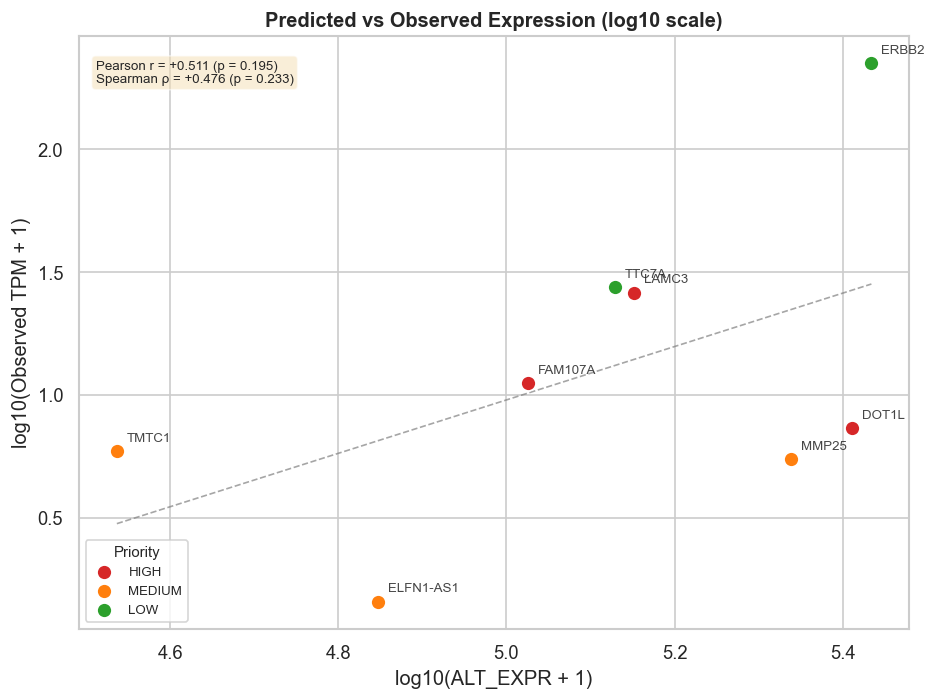

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter_with_regression(ax, "log10_ALT_EXPR", "log10_TPM", df,
                        "log10(ALT_EXPR + 1)",
                        "log10(Observed TPM + 1)",
                        "Predicted vs Observed Expression (log10 scale)")
plt.tight_layout()
plt.show()

## 5. Scatter: Predicted Expression vs Raw Counts

Raw counts avoid TPM normalisation artefacts and may show a cleaner relationship with predicted expression.

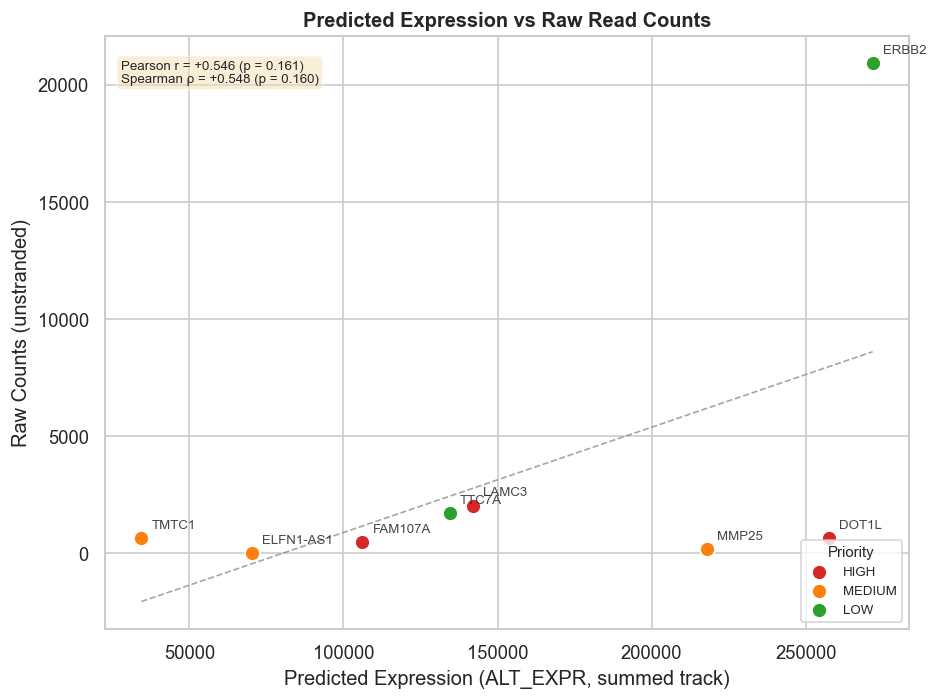

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter_with_regression(ax, "ALT_EXPR", "unstranded", df,
                        "Predicted Expression (ALT_EXPR, summed track)",
                        "Raw Counts (unstranded)",
                        "Predicted Expression vs Raw Read Counts")
plt.tight_layout()
plt.show()

## 6. Correlation Summary Table

Systematically compute Pearson and Spearman correlations for all comparison pairs in both raw and log₁₀ transforms.

In [9]:
def corr_row(label, x_vals, y_vals, transform="none"):
    """Compute a row of correlation statistics."""
    if transform == "log10":
        x_vals = np.log10(x_vals + 1)
        y_vals = np.log10(y_vals + 1)
    r, p_r = pearsonr(x_vals, y_vals)
    rho, p_s = spearmanr(x_vals, y_vals)
    return {"Comparison": label, "Transform": transform, "n": len(x_vals),
            "Pearson r": round(r, 4), "Pearson p": round(p_r, 4),
            "Spearman rho": round(rho, 4), "Spearman p": round(p_s, 4)}

expressed = df[df["EXPRESSED"] == True]

rows = [
    corr_row("ALT_EXPR vs TPM", df["ALT_EXPR"], df["OBSERVED_TPM"]),
    corr_row("ALT_EXPR vs TPM", df["ALT_EXPR"], df["OBSERVED_TPM"], "log10"),
    corr_row("REF_EXPR vs TPM", df["REF_EXPR"], df["OBSERVED_TPM"]),
    corr_row("REF_EXPR vs TPM", df["REF_EXPR"], df["OBSERVED_TPM"], "log10"),
    corr_row("LOG2_FC vs TPM", df["LOG2_FC"], df["OBSERVED_TPM"]),
    corr_row("ALT_EXPR vs raw counts", df["ALT_EXPR"], df["unstranded"]),
    corr_row("ALT_EXPR vs raw counts", df["ALT_EXPR"], df["unstranded"], "log10"),
    corr_row("ALT_EXPR vs TPM (expressed)", expressed["ALT_EXPR"], expressed["OBSERVED_TPM"]),
]
corr_summary = pd.DataFrame(rows)

# Style: highlight significant p-values
def highlight_sig(val):
    if isinstance(val, float) and val < 0.05:
        return "font-weight: bold; color: green"
    return ""

display(corr_summary.style.map(highlight_sig, subset=["Pearson p", "Spearman p"])
        .format(precision=4).set_caption("Correlation Summary"))

,Comparison,Transform,n,Pearson r,Pearson p,Spearman rho,Spearman p
0,ALT_EXPR vs TPM,none,8,0.5479,0.1597,0.4762,0.2329
1,ALT_EXPR vs TPM,log10,8,0.5112,0.1954,0.4762,0.2329
2,REF_EXPR vs TPM,none,8,0.5496,0.1582,0.4762,0.2329
3,REF_EXPR vs TPM,log10,8,0.5116,0.1950,0.4762,0.2329
4,LOG2_FC vs TPM,none,8,-0.4725,0.2371,-0.3571,0.3851
5,ALT_EXPR vs raw counts,none,8,0.5464,0.1611,0.5476,0.1600
6,ALT_EXPR vs raw counts,log10,8,0.4298,0.2878,0.5476,0.1600
7,ALT_EXPR vs TPM (expressed),none,7,0.5213,0.2302,0.2857,0.5345


## 7. Bar Chart: Rescaled Predicted vs Observed Expression

ALT_EXPR is min-max rescaled to the TPM range so both measures can be compared on the same axis. Original ALT_EXPR values are annotated above the bars.

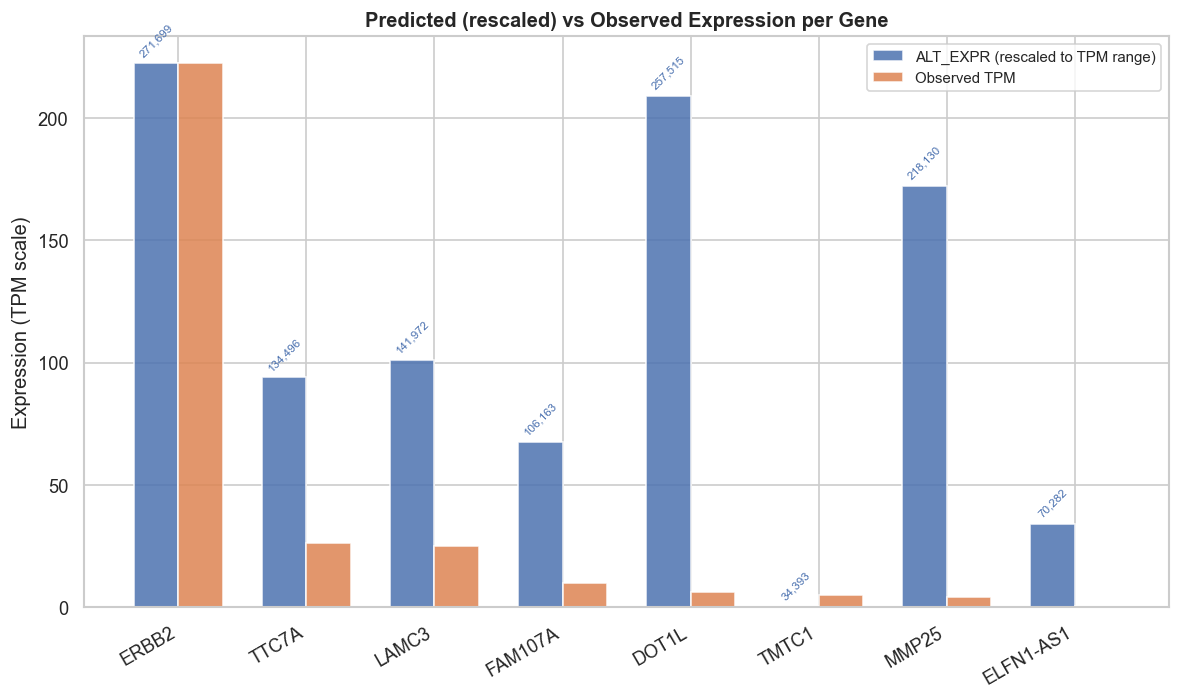

In [10]:
# Min-max rescale ALT_EXPR to the TPM range
alt_min, alt_max = df["ALT_EXPR"].min(), df["ALT_EXPR"].max()
tpm_min, tpm_max = df["OBSERVED_TPM"].min(), df["OBSERVED_TPM"].max()
df["ALT_EXPR_RESCALED"] = (
    (df["ALT_EXPR"] - alt_min) / (alt_max - alt_min) * (tpm_max - tpm_min) + tpm_min
)

# Sort by observed TPM descending
plot_df = df.sort_values("OBSERVED_TPM", ascending=False).copy()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(plot_df))
width = 0.35

bars1 = ax.bar(x - width / 2, plot_df["ALT_EXPR_RESCALED"], width,
               label="ALT_EXPR (rescaled to TPM range)", color="#4c72b0", alpha=0.85)
bars2 = ax.bar(x + width / 2, plot_df["OBSERVED_TPM"], width,
               label="Observed TPM", color="#dd8452", alpha=0.85)

# Annotate with original ALT_EXPR values
for i, (_, row) in enumerate(plot_df.iterrows()):
    ax.text(i - width / 2, row["ALT_EXPR_RESCALED"] + 3,
            f"{row['ALT_EXPR']:,.0f}", ha="center", fontsize=7, color="#4c72b0", rotation=45)

ax.set_xticks(x)
ax.set_xticklabels(plot_df["GENE"], rotation=30, ha="right")
ax.set_ylabel("Expression (TPM scale)")
ax.set_title("Predicted (rescaled) vs Observed Expression per Gene", fontweight="bold")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 8. Heatmap: Multi-Metric Summary per Gene

A z-score normalised heatmap showing all scoring dimensions at once: log₂FC, VAF, log₁₀(TPM), NMD status, and vaccine priority. Cell annotations show original values.

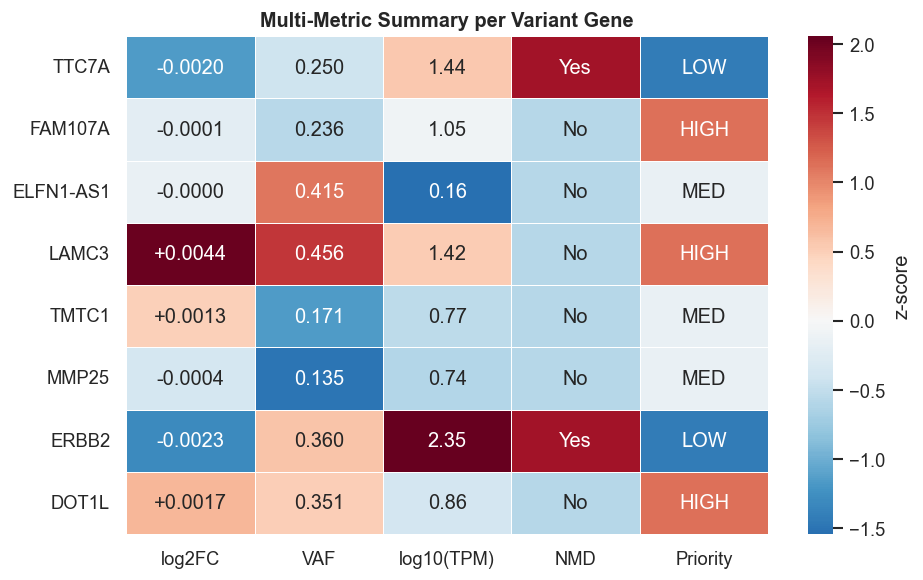

In [12]:
# Build heatmap matrix
heat_cols = {
    "log2FC": "LOG2_FC",
    "VAF": "VAF",
    "log10(TPM)": "log10_TPM",
    "NMD": "NMD_NUM",
    "Priority": "PRIORITY_NUM",
}

heat_data = df.set_index("GENE")[list(heat_cols.values())].copy()
heat_data.columns = list(heat_cols.keys())

# Annotation matrix with original values (readable format)
annot_data = heat_data.copy()
annot_data["log2FC"] = annot_data["log2FC"].map(lambda v: f"{v:+.4f}")
annot_data["VAF"] = annot_data["VAF"].map(lambda v: f"{v:.3f}")
annot_data["log10(TPM)"] = annot_data["log10(TPM)"].map(lambda v: f"{v:.2f}")
annot_data["NMD"] = annot_data["NMD"].map({0: "No", 1: "Yes"})
annot_data["Priority"] = annot_data["Priority"].map({3: "HIGH", 2: "MED", 1: "LOW"})

# Z-score normalise for colour scale
from scipy.stats import zscore
heat_z = heat_data.apply(zscore)

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(heat_z, annot=annot_data.values, fmt="",
            cmap="RdBu_r", center=0, linewidths=0.5,
            cbar_kws={"label": "z-score"}, ax=ax)
ax.set_title("Multi-Metric Summary per Variant Gene", fontweight="bold")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

## 9. Influence Analysis: Effect of Removing ERBB2

ERBB2 (TPM = 222, raw counts = 20,912) is a high-leverage point. How much does it drive the observed correlations? We recompute all correlations with and without ERBB2 and show side-by-side scatter plots.

,Comparison,Pearson r (all),Pearson r (no ERBB2),Δr,Spearman ρ (all),Spearman ρ (no ERBB2),Δρ
0,ALT_EXPR vs TPM,0.547900,0.059900,-0.488100,0.476200,0.214300,-0.261900
1,ALT_EXPR vs raw counts,0.546400,0.037300,-0.509100,0.547600,0.321400,-0.226200
2,LOG2_FC vs TPM,-0.472500,0.137800,0.610300,-0.357100,-0.035700,0.321400


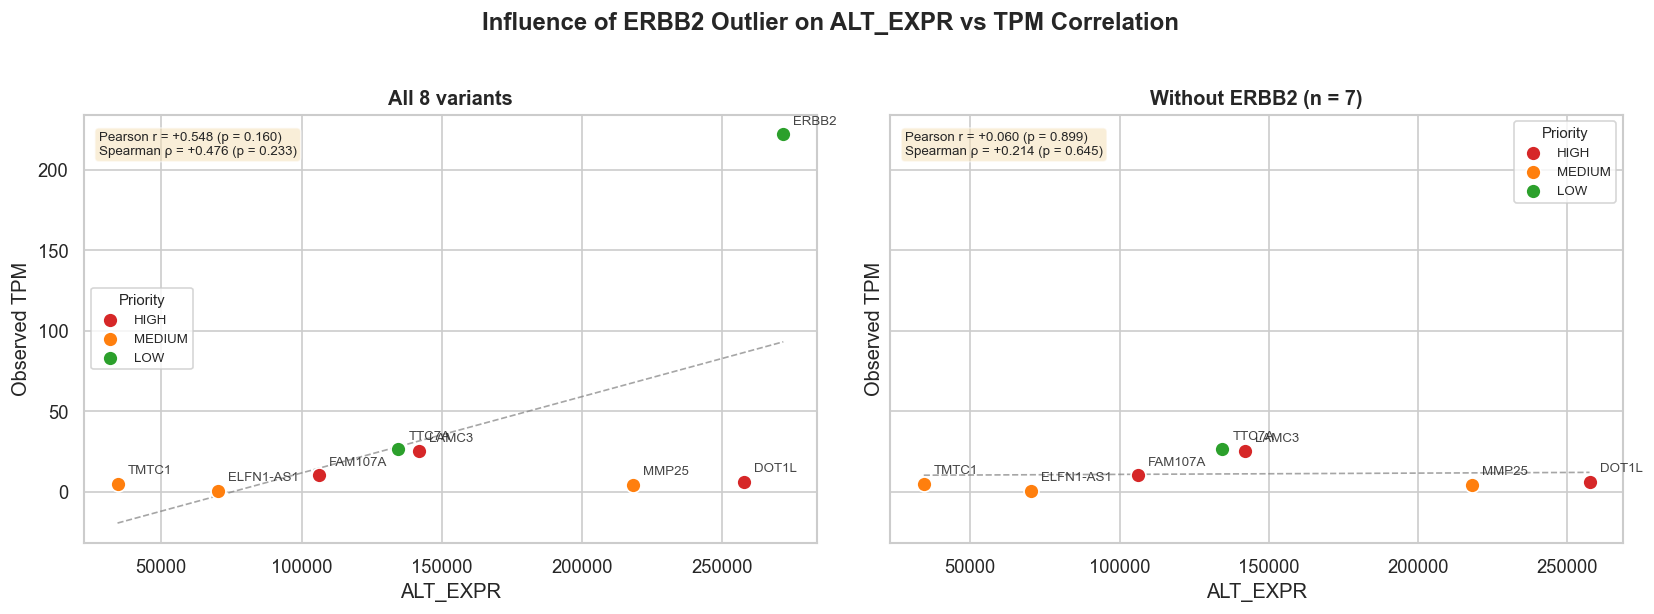

In [13]:
df_no_erbb2 = df[df["GENE"] != "ERBB2"].copy()

# Comparison table
influence_rows = []
for label, x_col, y_col in [
    ("ALT_EXPR vs TPM", "ALT_EXPR", "OBSERVED_TPM"),
    ("ALT_EXPR vs raw counts", "ALT_EXPR", "unstranded"),
    ("LOG2_FC vs TPM", "LOG2_FC", "OBSERVED_TPM"),
]:
    r_all, _ = pearsonr(df[x_col], df[y_col])
    r_no, _  = pearsonr(df_no_erbb2[x_col], df_no_erbb2[y_col])
    rho_all, _ = spearmanr(df[x_col], df[y_col])
    rho_no, _  = spearmanr(df_no_erbb2[x_col], df_no_erbb2[y_col])
    influence_rows.append({
        "Comparison": label,
        "Pearson r (all)": round(r_all, 4),
        "Pearson r (no ERBB2)": round(r_no, 4),
        "Δr": round(r_no - r_all, 4),
        "Spearman ρ (all)": round(rho_all, 4),
        "Spearman ρ (no ERBB2)": round(rho_no, 4),
        "Δρ": round(rho_no - rho_all, 4),
    })

influence_df = pd.DataFrame(influence_rows)
display(influence_df.style.set_caption("Influence of ERBB2 on Correlations"))

# Side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
scatter_with_regression(axes[0], "ALT_EXPR", "OBSERVED_TPM", df,
                        "ALT_EXPR", "Observed TPM",
                        "All 8 variants")
scatter_with_regression(axes[1], "ALT_EXPR", "OBSERVED_TPM", df_no_erbb2,
                        "ALT_EXPR", "Observed TPM",
                        "Without ERBB2 (n = 7)")
plt.suptitle("Influence of ERBB2 Outlier on ALT_EXPR vs TPM Correlation",
             fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 10. Statistical Power Analysis

With only n = 8 variants, we have very limited statistical power. This section computes:
- The **minimum detectable correlation** at α = 0.05, power = 0.80
- A **power curve** showing how power increases with sample size for the observed r ≈ 0.55
- The **sample size needed** to detect r ≈ 0.55 with 80% power

Observed r = 0.548 at n = 8
Minimum detectable r at n = 8: 0.849
Power at observed r = 0.548: 0.280
Sample size needed for 80% power at r = 0.548: n = 24


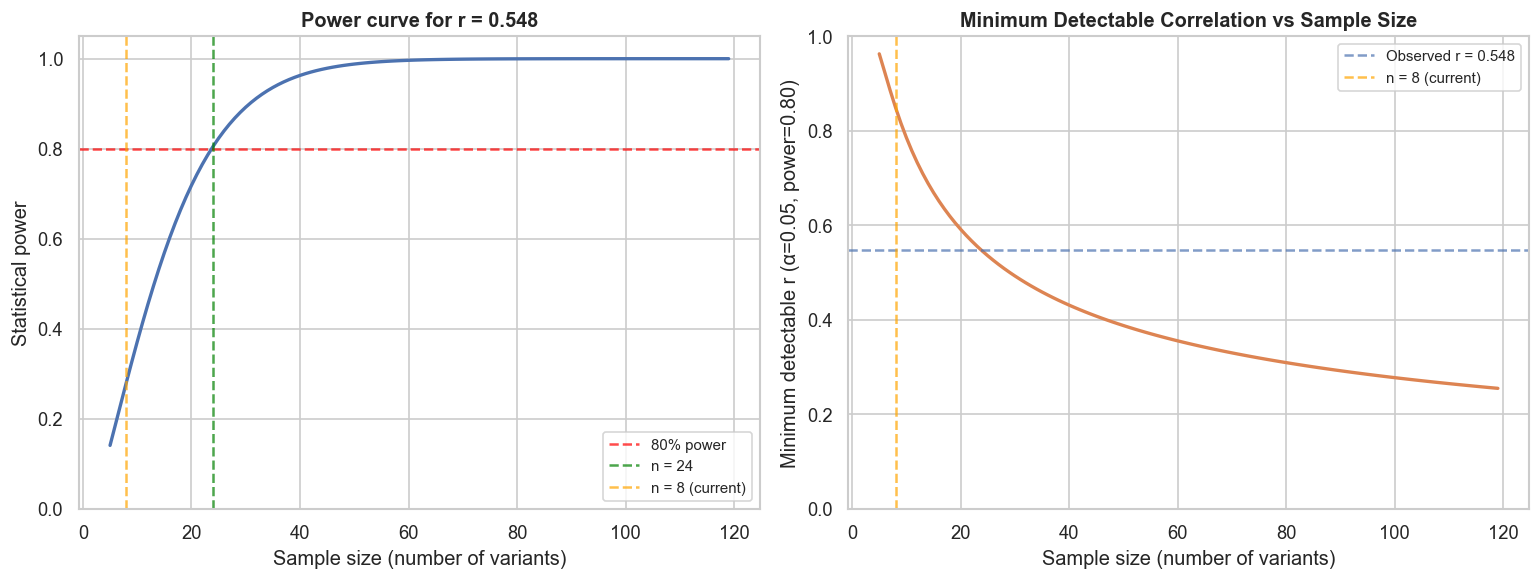

In [14]:
def power_for_r(r, n, alpha=0.05):
    """Compute the statistical power for a two-sided test of Pearson r.
    
    Uses Fisher's z-transform approach:
      z = arctanh(r) * sqrt(n - 3)
    Under H1, z ~ N(arctanh(r)*sqrt(n-3), 1).
    """
    from scipy.stats import norm
    if n <= 3:
        return 0.0
    z_alpha = norm.ppf(1 - alpha / 2)
    z_r = np.arctanh(r) * np.sqrt(n - 3)
    # Power = P(reject H0 | r) = P(|Z| > z_alpha)
    power = 1 - norm.cdf(z_alpha - z_r) + norm.cdf(-z_alpha - z_r)
    return power

def min_detectable_r(n, alpha=0.05, target_power=0.80):
    """Find the minimum r detectable at given n, alpha, and power via bisection."""
    from scipy.optimize import brentq
    try:
        return brentq(lambda r: power_for_r(r, n, alpha) - target_power, 0.01, 0.99)
    except ValueError:
        return np.nan

# --- Key results ---
r_obs = 0.548  # observed Pearson r (ALT_EXPR vs TPM)
n_obs = 8

min_r = min_detectable_r(n_obs)
power_at_obs = power_for_r(r_obs, n_obs)

# Sample size needed for 80% power at r = 0.548
n_range = np.arange(5, 120)
powers = [power_for_r(r_obs, n) for n in n_range]
n_needed = n_range[np.searchsorted(powers, 0.80)]

print(f"Observed r = {r_obs:.3f} at n = {n_obs}")
print(f"Minimum detectable r at n = {n_obs}: {min_r:.3f}")
print(f"Power at observed r = {r_obs}: {power_at_obs:.3f}")
print(f"Sample size needed for 80% power at r = {r_obs}: n = {n_needed}")

# --- Power curve ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: power vs sample size for observed r
ax = axes[0]
ax.plot(n_range, powers, color="#4c72b0", linewidth=2)
ax.axhline(0.80, color="red", linestyle="--", alpha=0.7, label="80% power")
ax.axvline(n_needed, color="green", linestyle="--", alpha=0.7, label=f"n = {n_needed}")
ax.axvline(n_obs, color="orange", linestyle="--", alpha=0.7, label=f"n = {n_obs} (current)")
ax.set_xlabel("Sample size (number of variants)")
ax.set_ylabel("Statistical power")
ax.set_title(f"Power curve for r = {r_obs:.3f}", fontweight="bold")
ax.legend(fontsize=9)
ax.set_ylim(0, 1.05)

# Right: minimum detectable r vs sample size
ax2 = axes[1]
n_range2 = np.arange(5, 120)
min_rs = [min_detectable_r(n) for n in n_range2]
ax2.plot(n_range2, min_rs, color="#dd8452", linewidth=2)
ax2.axhline(r_obs, color="#4c72b0", linestyle="--", alpha=0.7, label=f"Observed r = {r_obs}")
ax2.axvline(n_obs, color="orange", linestyle="--", alpha=0.7, label=f"n = {n_obs} (current)")
ax2.set_xlabel("Sample size (number of variants)")
ax2.set_ylabel("Minimum detectable r (α=0.05, power=0.80)")
ax2.set_title("Minimum Detectable Correlation vs Sample Size", fontweight="bold")
ax2.legend(fontsize=9)
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Moderate positive trend (r ≈ 0.55)** between predicted and observed expression, but **not statistically significant** at n = 8.
2. **ERBB2 is a high-leverage outlier** — removing it substantially changes the correlation. Results should not depend on a single data point.
3. **All variants are predicted Neutral** (log₂FC < ±0.005), so we cannot validate the model's ability to predict expression *changes* — only expression *magnitude*.
4. **~24 variants needed** for 80% power to detect the observed effect size. Expanding to HIGH + MODERATE impact variants (46 total) would provide adequate statistical power.
5. The predicted expression sums and per-gene TPM measure fundamentally different things — any correlation is a rough consistency check, not a direct validation.